In [1]:
#!gcloud auth login

In [48]:
import sys
import os
print(sys.executable)

C:\Users\lpl_z\anaconda3\envs\the_impostor\python.exe


In [3]:
#!pip install -r requirements.txt


In [4]:
#!gsutil -m cp -r gs://the_impostor_hunt/data ./  

In [5]:
# ler o arquivo data/train.csv
# para cada id na tabela train_roles no formato com 4 numeros (0001, 0002, 0010)
# ler cada um dos arquivos na pasta data/train/pasta

In [6]:
import pandas as pd
import json
import re
import string
import nltk
import math
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack



In [7]:
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lpl_z\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lpl_z\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lpl_z\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
train_rules = pd.read_csv("data/train.csv")
train_rules.head()

,id,real_text_id
0,0,1
1,1,2
2,2,1
3,3,2
4,4,2


In [9]:
train_rules['fake_text_id'] = train_rules['real_text_id'].apply(lambda x: 2 if x == 1 else 1)
train_rules['article'] = train_rules['id'].apply(lambda x: str(x).zfill(4))

In [10]:
train_rules.head()

,id,real_text_id,fake_text_id,article
0,0,1,2,0000
1,1,2,1,0001
2,2,1,2,0002
3,3,2,1,0003
4,4,2,1,0004


In [11]:
def cria_caminho_article(text_id, article):
    caminho = f"data/train/article_{article}/file_{text_id}.txt"
    return caminho

def leitura_arquivo(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read().strip()
    return text

train_rules['real_text_file'] = train_rules[['real_text_id', 'article']].apply(lambda x: cria_caminho_article(x['real_text_id'], x['article']), axis=1)
train_rules['fake_text_file'] = train_rules[['fake_text_id', 'article']].apply(lambda x: cria_caminho_article(x['fake_text_id'], x['article']), axis=1)
train_rules['real_text'] = train_rules['real_text_file'].apply(leitura_arquivo)
train_rules['fake_text'] = train_rules['fake_text_file'].apply(leitura_arquivo)
train_rules.head()

,id,real_text_id,fake_text_id,article,real_text_file,fake_text_file,real_text,fake_text
0,0,1,2,0000,data/train/article_0000/file_1.txt,data/train/article_0000/file_2.txt,The VIRSA (Visible Infrared Survey Telescope A...,The China relay network has released a signifi...
1,1,2,1,0001,data/train/article_0001/file_2.txt,data/train/article_0001/file_1.txt,The project aims to achieve an accuracy level ...,China\nThe goal of this project involves achie...
2,2,1,2,0002,data/train/article_0002/file_1.txt,data/train/article_0002/file_2.txt,Scientists can learn about how galaxies form a...,Dinosaur eggshells offer clues about what dino...
3,3,2,1,0003,data/train/article_0003/file_2.txt,data/train/article_0003/file_1.txt,The importance for understanding how stars evo...,China\nThe study suggests that multiple star s...
4,4,2,1,0004,data/train/article_0004/file_2.txt,data/train/article_0004/file_1.txt,Analyzing how fast stars rotate within a galax...,Dinosaur Rex was excited about his new toy set...


In [12]:
# Criar os dois dataframes com as colunas relevantes, incluindo o artigo
df_real = train_rules[['article', 'real_text']].copy()
df_real.columns = ['article', 'texto']  # Padroniza nomes
df_real['label'] = 1

df_fake = train_rules[['article', 'fake_text']].copy()
df_fake.columns = ['article', 'texto']
df_fake['label'] = 0

# Concatenar os dois dataframes (real + fake)
df_completo = pd.concat([df_real, df_fake], ignore_index=True)

# Exibir resultado
df_completo.head()

,article,texto,label
0,0000,The VIRSA (Visible Infrared Survey Telescope A...,1
1,0001,The project aims to achieve an accuracy level ...,1
2,0002,Scientists can learn about how galaxies form a...,1
3,0003,The importance for understanding how stars evo...,1
4,0004,Analyzing how fast stars rotate within a galax...,1


In [13]:
n_artigo = '0090'
print(df_completo[df_completo['article']==n_artigo].label.iloc[0])
df_completo[df_completo['article']==n_artigo].texto.iloc[0]

1


'A key focus of modern cosmology is to understand how galaxies form. The current standard model suggests that structure developed from small fluctuations in matter during recombination (about one part in 105, as noted in Cosmic Microwave Background experiments) through hierarchical mergers of dark matter. Over time, the gravity of the largest mass concentrations became strong enough to attract and gather the gas necessary for forming early galaxies. It is believed that the first stars generated ultraviolet light, which reionized the Universe, ending the Dark Ages that followed recombination. Advances in technology are helping astronomers bridge the gap between CMB data from 380,000 years after the Big Bang and initial galaxy observations. Utilizing the imaging capabilities of the Advanced Camera for Surveys (ACS) on the Hubble Space Telescope and the spectroscopic abilities of the FORS2 instrument at the ESO/VLT, our team has identified a significant number of galaxies at redshifts up 

In [14]:
print(df_completo[df_completo['article']==n_artigo].label.iloc[1])
df_completo[df_completo['article']==n_artigo].texto.iloc[1]

0


"A main focus of modern cosmology is to understand how galaxies form. The current standard model suggests that structure developed through hierarchical mergers of dark matter concentrations, starting from initial tiny fluctuations in matter, about one part in 100,000 at recombination, as shown in CMB experiments. Over time, large mass aggregates' gravity was strong enough to attract and concentrate gas, leading to the birth of early galaxies. The first stars are believed to have emitted the ultraviolet light necessary to reionize the Universe, marking the end of the Dark Ages that followed recombination. Astronomers are bridging the time gap between CMB measurements, which represent the Universe 380,000 years after the Big Bang, and pale galaxies’ observations due to progressively advanced instruments. Utilizing the imaging capabilities of the Advanced Camera for Surveys (ACS) aboard the Hubble Space Telescope and the spectroscopic power of the FORS2 instrument at the ESO/VLT, our team

<Axes: title={'center': 'Distribuição das classes (real vs. fake)'}, xlabel='label'>

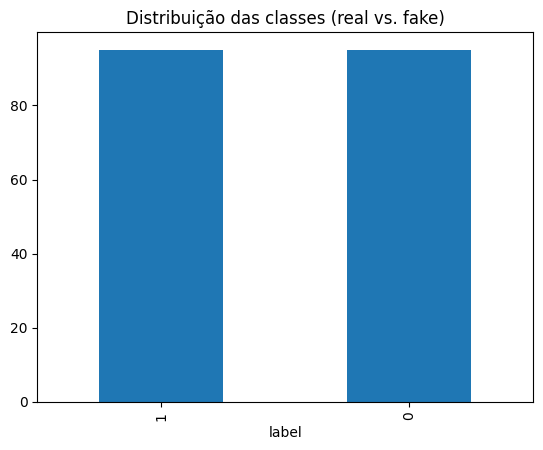

In [15]:
df_completo['label'].value_counts().plot(kind='bar', title='Distribuição das classes (real vs. fake)')


In [16]:
df_completo['texto_len'] = df_completo['texto'].apply(lambda x: len(x.split()))
df_completo.groupby('label')['texto_len'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,95.0,378.578947,492.487705,0.0,150.5,219.0,365.5,4158.0
1,95.0,265.600000,101.016262,91.0,196.0,243.0,308.5,614.0


In [17]:
artigos = df_completo['article'].unique()
sim_scores = []

vectorizer = TfidfVectorizer()

for a in artigos:
    pares = df_completo[df_completo['article'] == a]
    if len(pares) == 2:
        vectors = vectorizer.fit_transform(pares['texto'])
        score = cosine_similarity(vectors[0], vectors[1])[0][0]
        sim_scores.append(score)

print(f'Média de similaridade: {sum(sim_scores)/len(sim_scores):.2f}')

Média de similaridade: 0.49


In [18]:
#real_text

In [19]:
#fake_text

In [20]:
# obtendo caracteres não latinos
def count_non_latin(text):
    return len(re.findall(r'[^\x00-\x7F]', text))  # ASCII padrão

df_completo['non_latin_chars'] = df_completo['texto'].apply(count_non_latin)

In [21]:
df_completo.sort_values(by='non_latin_chars', ascending=False)[:10]

,article,texto,label,texto_len,non_latin_chars
178,0083,A key element for fully understanding galactic...,0,4158,5007
187,0092,FORS1 and FORS2 are early instruments of the V...,0,934,1353
183,0088,Danish Minister visits ESO in Chile\n\nOn Octo...,0,952,1298
179,0084,Halftoning has been utilized in printing for c...,0,1003,1296
155,0060,The Nasmyth rotator will utilize the Nasmyth A...,0,928,1280
181,0086,The formation and presence of stars in the cen...,0,1018,1259
156,0061,"To progress toward this goal, we used the ESO ...",0,836,1224
168,0073,The UVES spectrum for G29-23 displays the sulp...,0,957,1221
166,0071,Two new science projects set for Period 84 foc...,0,982,1218
161,0066,FLAMES Study of Old Open Clusters: Insights on...,0,925,1217


In [22]:
df_completo.groupby('label')[['texto_len', 'non_latin_chars']].describe()

texto_len                                                             \
          count        mean         std   min    25%    50%    75%     max   
label                                                                        
0          95.0  378.578947  492.487705   0.0  150.5  219.0  365.5  4158.0   
1          95.0  265.600000  101.016262  91.0  196.0  243.0  308.5   614.0   

      non_latin_chars                                                      
                count        mean         std  min  25%  50%  75%     max  
label                                                                      
0                95.0  274.989474  674.522408  0.0  0.0  0.0  4.5  5007.0  
1                95.0    2.926316    3.898287  0.0  0.0  2.0  4.0    20.0

In [23]:
# números de pontuações

In [24]:
df_completo['num_pontuacao'] = df_completo['texto'].apply(lambda x: sum(1 for c in x if c in string.punctuation))

In [25]:
df_completo

,article,texto,label,texto_len,non_latin_chars,num_pontuacao
0,0000,The VIRSA (Visible Infrared Survey Telescope A...,1,304,0,32
1,0001,The project aims to achieve an accuracy level ...,1,137,1,23
2,0002,Scientists can learn about how galaxies form a...,1,159,2,16
3,0003,The importance for understanding how stars evo...,1,262,0,17
4,0004,Analyzing how fast stars rotate within a galax...,1,123,0,19
...,...,...,...,...,...,...
185,0090,A main focus of modern cosmology is to underst...,0,352,5,73
186,0091,"APEX, as its name suggests, serves as a guide ...",0,312,2,39
187,0092,FORS1 and FORS2 are early instruments of the V...,0,934,1353,364
188,0093,The observations of the Pluto-Charon system an...,0,174,4,22


In [26]:
df_completo.groupby('label')['num_pontuacao'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,95.0,115.389474,249.570409,0.0,20.0,33.0,57.0,2156.0
1,95.0,47.505263,28.881222,13.0,27.0,43.0,61.0,163.0


In [27]:
df_completo['num_linhas'] = df_completo['texto'].apply(lambda x: x.count('\n'))

In [28]:
df_completo.groupby('label')['num_linhas'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,95.0,15.294737,34.150130,0.0,0.0,1.0,5.5,250.0
1,95.0,3.989474,4.609183,0.0,0.0,2.0,7.0,19.0


In [29]:
df_completo

,article,texto,label,texto_len,non_latin_chars,num_pontuacao,num_linhas
0,0000,The VIRSA (Visible Infrared Survey Telescope A...,1,304,0,32,0
1,0001,The project aims to achieve an accuracy level ...,1,137,1,23,0
2,0002,Scientists can learn about how galaxies form a...,1,159,2,16,1
3,0003,The importance for understanding how stars evo...,1,262,0,17,1
4,0004,Analyzing how fast stars rotate within a galax...,1,123,0,19,0
...,...,...,...,...,...,...,...
185,0090,A main focus of modern cosmology is to underst...,0,352,5,73,0
186,0091,"APEX, as its name suggests, serves as a guide ...",0,312,2,39,0
187,0092,FORS1 and FORS2 are early instruments of the V...,0,934,1353,364,65
188,0093,The observations of the Pluto-Charon system an...,0,174,4,22,0


In [30]:
# proporção de stopword
stopwords_set = set(stopwords.words('english'))

def stopword_ratio(text):
    words = word_tokenize(text.lower())
    if len(words) == 0:
        return 0
    stop_count = sum(1 for w in words if w in stopwords_set)
    return stop_count / len(words)

df_completo['stopword_ratio'] = df_completo['texto'].apply(stopword_ratio)

In [31]:
# tamanho das words
# se for maior que 15 ele soma 1
df_completo['long_words'] = df_completo['texto'].apply(lambda x: sum(1 for w in x.split() if len(w) > 15))

In [32]:
df_completo.head()

,article,texto,label,texto_len,non_latin_chars,num_pontuacao,num_linhas,stopword_ratio,long_words
0,0000,The VIRSA (Visible Infrared Survey Telescope A...,1,304,0,32,0,0.186335,0
1,0001,The project aims to achieve an accuracy level ...,1,137,1,23,0,0.248366,0
2,0002,Scientists can learn about how galaxies form a...,1,159,2,16,1,0.274854,0
3,0003,The importance for understanding how stars evo...,1,262,0,17,1,0.265683,0
4,0004,Analyzing how fast stars rotate within a galax...,1,123,0,19,0,0.224638,0


In [33]:
df_completo.sort_values(by='long_words', ascending=False)[:10]

,article,texto,label,texto_len,non_latin_chars,num_pontuacao,num_linhas,stopword_ratio,long_words
178,0083,A key element for fully understanding galactic...,0,4158,5007,2156,250,0.022150,462
183,0088,Danish Minister visits ESO in Chile\n\nOn Octo...,0,952,1298,420,77,0.008396,115
156,0061,"To progress toward this goal, we used the ESO ...",0,836,1224,370,62,0.013632,98
187,0092,FORS1 and FORS2 are early instruments of the V...,0,934,1353,364,65,0.027899,98
182,0087,On-sky Testing of the Multi-Conjugate Adaptive...,0,901,1155,345,61,0.019409,98
161,0066,FLAMES Study of Old Open Clusters: Insights on...,0,925,1217,374,72,0.041301,97
181,0086,The formation and presence of stars in the cen...,0,1018,1259,385,66,0.051906,97
166,0071,Two new science projects set for Period 84 foc...,0,982,1218,353,60,0.046848,96
175,0080,"The goal of this one-day workshop, part of the...",0,912,1194,361,63,0.036397,95
179,0084,Halftoning has been utilized in printing for c...,0,1003,1296,375,71,0.055556,93


In [34]:
def entropy(text):
    if len(text) == 0:
        return 0
    probs = [v / len(text) for v in Counter(text).values()]
    return -sum(p * math.log2(p) for p in probs if p > 0)

# Aplicar no dataframe
df_completo['entropia'] = df_completo['texto'].apply(entropy)

In [38]:
df_completo.head()

,article,texto,label,texto_len,non_latin_chars,num_pontuacao,num_linhas,stopword_ratio,long_words,entropia
0,0000,The VIRSA (Visible Infrared Survey Telescope A...,1,304,0,32,0,0.186335,0,4.468973
1,0001,The project aims to achieve an accuracy level ...,1,137,1,23,0,0.248366,0,4.430374
2,0002,Scientists can learn about how galaxies form a...,1,159,2,16,1,0.274854,0,4.299045
3,0003,The importance for understanding how stars evo...,1,262,0,17,1,0.265683,0,4.299974
4,0004,Analyzing how fast stars rotate within a galax...,1,123,0,19,0,0.224638,0,4.263312


In [39]:
df_completo.groupby('label')['entropia'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,95.0,4.608106,0.898071,0.000000,4.382922,4.464607,4.613921,5.947896
1,95.0,4.486849,0.101697,4.263312,4.414429,4.494256,4.556778,4.755636


In [40]:
df_completo.head()

,article,texto,label,texto_len,non_latin_chars,num_pontuacao,num_linhas,stopword_ratio,long_words,entropia
0,0000,The VIRSA (Visible Infrared Survey Telescope A...,1,304,0,32,0,0.186335,0,4.468973
1,0001,The project aims to achieve an accuracy level ...,1,137,1,23,0,0.248366,0,4.430374
2,0002,Scientists can learn about how galaxies form a...,1,159,2,16,1,0.274854,0,4.299045
3,0003,The importance for understanding how stars evo...,1,262,0,17,1,0.265683,0,4.299974
4,0004,Analyzing how fast stars rotate within a galax...,1,123,0,19,0,0.224638,0,4.263312


✅ texto_len → como proxy do "tamanho geral"

✅ stopword_ratio → comportamento linguístico

✅ entropia → complexidade/ruído

In [41]:
# Selecionar apenas as features úteis e o rótulo
df_final = df_completo[['article', 'texto', 'texto_len', 'stopword_ratio', 'entropia', 'label']].copy()

df_final.head()

,article,texto,texto_len,stopword_ratio,entropia,label
0,0000,The VIRSA (Visible Infrared Survey Telescope A...,304,0.186335,4.468973,1
1,0001,The project aims to achieve an accuracy level ...,137,0.248366,4.430374,1
2,0002,Scientists can learn about how galaxies form a...,159,0.274854,4.299045,1
3,0003,The importance for understanding how stars evo...,262,0.265683,4.299974,1
4,0004,Analyzing how fast stars rotate within a galax...,123,0.224638,4.263312,1


In [42]:
df_final.head()

,article,texto,texto_len,stopword_ratio,entropia,label
0,0000,The VIRSA (Visible Infrared Survey Telescope A...,304,0.186335,4.468973,1
1,0001,The project aims to achieve an accuracy level ...,137,0.248366,4.430374,1
2,0002,Scientists can learn about how galaxies form a...,159,0.274854,4.299045,1
3,0003,The importance for understanding how stars evo...,262,0.265683,4.299974,1
4,0004,Analyzing how fast stars rotate within a galax...,123,0.224638,4.263312,1


In [43]:
X = df_final[['texto_len', 'stopword_ratio', 'entropia']]
y = df_final['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.75      0.72        24
           1       0.73      0.67      0.70        24

    accuracy                           0.71        48
   macro avg       0.71      0.71      0.71        48
weighted avg       0.71      0.71      0.71        48



In [44]:
# Vetorização TF-IDF
tfidf = TfidfVectorizer(max_features=500)
X_tfidf = tfidf.fit_transform(df_final['texto'])

# Normalização das features manuais
from sklearn.preprocessing import StandardScaler
X_extra = StandardScaler().fit_transform(df_final[['texto_len', 'stopword_ratio', 'entropia']])

# Combinação
X_combined = hstack([X_tfidf, X_extra])

# Modelo (idêntico ao anterior)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, stratify=y, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.79      0.78        24
           1       0.78      0.75      0.77        24

    accuracy                           0.77        48
   macro avg       0.77      0.77      0.77        48
weighted avg       0.77      0.77      0.77        48



In [45]:
# TF-IDF com n-grams, stopwords e mais features
tfidf = TfidfVectorizer(
    max_features=1000,
    stop_words='english',
    sublinear_tf=True
)
#tfidf = TfidfVectorizer(max_features=500)
#tfidf = TfidfVectorizer(max_features=500)

X_tfidf = tfidf.fit_transform(df_final['texto'])

# Normalização das features manuais
scaler = StandardScaler()
X_extra = scaler.fit_transform(df_final[['texto_len', 'stopword_ratio', 'entropia']])

# Combinação
X_combined = hstack([X_tfidf, X_extra])

# Rótulo
y = df_final['label']

# Split com estratificação
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, stratify=y, random_state=42
)

# Modelo
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Avaliação
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.63      0.69        19
           1       0.68      0.79      0.73        19

    accuracy                           0.71        38
   macro avg       0.72      0.71      0.71        38
weighted avg       0.72      0.71      0.71        38



In [46]:
X_test

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 6057 stored elements and shape (38, 1003)>

In [ ]:
# Vetorização TF-IDF
tfidf = TfidfVectorizer(max_features=500)
X_tfidf = tfidf.fit_transform(df_final['texto'])

# Normalização das features manuais
from sklearn.preprocessing import StandardScaler
X_extra = StandardScaler().fit_transform(df_final[['texto_len', 'stopword_ratio', 'entropia']])

# Combinação
X_combined = hstack([X_tfidf, X_extra])

# Modelo (idêntico ao anterior)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, stratify=y, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:

# Vetorização TF-IDF
tfidf = TfidfVectorizer(max_features=500)
X_tfidf = tfidf.fit_transform(df_final['texto'])

# Normalização das features manuais
X_extra = StandardScaler().fit_transform(df_final[['texto_len', 'stopword_ratio', 'entropia']])

# Combinação e conversão para CSR (permite indexação)
X_combined = hstack([X_tfidf, X_extra])
X_combined = csr_matrix(X_combined)

# Rótulo
y = df_final['label'].values

# K-Fold Stratificado
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Armazena métricas
accuracies = []
precisions = []
recalls = []
f1s = []

for train_idx, test_idx in kf.split(X_combined, y):
    X_train, X_test = X_combined[train_idx], X_combined[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

    accuracies.append(acc)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

# Resultados médios
print("📊 Resultados médios em 5 folds:")
print(f"Accuracy:  {np.mean(accuracies):.2f}")
print(f"Precision: {np.mean(precisions):.2f}")
print(f"Recall:    {np.mean(recalls):.2f}")
print(f"F1-score:  {np.mean(f1s):.2f}")


In [ ]:
#!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


In [ ]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA disponível:", torch.cuda.is_available())
print("Nome da GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "Sem GPU")


In [51]:
data_path = "OneDrive/Área de Trabalho/the_impostor/data"
# Muda para o diretório /data
os.chdir(data_path)

for item in os.listdir(data_path):
    full_path = os.path.join(data_path, item)
    if os.path.isdir(full_path):
        print(f"Pasta encontrada: {full_path}")

FileNotFoundError: [WinError 3] O sistema não pode encontrar o caminho especificado: 'OneDrive/Área de Trabalho/the_impostor/data'

In [52]:
os.chdir(data_path)

FileNotFoundError: [WinError 3] O sistema não pode encontrar o caminho especificado: 'OneDrive/Área de Trabalho/the_impostor/data'